# Prerequisite

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import os
import pandas as pd

#image
from PIL import Image
import numpy as np

#pre-trained
import torchvision.models as models
import torch.nn as nn

# Access Torch to use device


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cpu device
num_workers = 2 cores


# Workshop II 01 early stopping
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ โดยการหยุกฝึกด้วย early stopping ฟร้อมวัดประสิทธิภาพ

## Data Processing

### Load Data


mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


unzip file

In [4]:
!unzip '/content/drive/MyDrive/AI workshop2/Week1(Early Stopping)/Dataset/Small_Data_CoV2.zip'

Archive:  /content/drive/MyDrive/AI workshop2/Week1(Early Stopping)/Dataset/Small_Data_CoV2.zip
   creating: Small_Data_CoV2_val/
   creating: Small_Data_CoV2_val/Covid/
   creating: Small_Data_CoV2_val/Covid/Patient (10)/
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132320.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132449.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132516.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132540.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132608.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132636.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132704.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132740.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132814.png  
  inflating:

### preparing data

make a unstructued data to structured data

In [ ]:
def mapping_csv(path:str):
  #Create empty lists
  filename = []
  label = []

  #read all file from subfolders
  for dirname, _, filenames in os.walk(f'{path}'):
    for file in filenames:
      f = os.path.join(dirname, file)
      if '.png' in f:
        filename.append(f)
        label.append(dirname.split('/')[3])

  #Create a dataframe
  df = pd.DataFrame({'filename':filename, 'label':label})
  return df


In [6]:
df_test = mapping_csv('/content/Small_Data_CoV2_test')
df_train = mapping_csv('/content/Small_Data_CoV2_train')
df_val = mapping_csv('/content/Small_Data_CoV2_val')

In [7]:
df_test

,filename,label
0,/content/Small_Data_CoV2_test/Covid/Patient (2...,Covid
1,/content/Small_Data_CoV2_test/Covid/Patient (2...,Covid
2,/content/Small_Data_CoV2_test/Covid/Patient (2...,Covid
3,/content/Small_Data_CoV2_test/Covid/Patient (2...,Covid
4,/content/Small_Data_CoV2_test/Covid/Patient (2...,Covid
...,...,...
270,/content/Small_Data_CoV2_test/Others/Patient (...,Others
271,/content/Small_Data_CoV2_test/Others/Patient (...,Others
272,/content/Small_Data_CoV2_test/Others/Patient (...,Others
273,/content/Small_Data_CoV2_test/Others/Patient (...,Others


label transform

In [ ]:
from sklearn.preprocessing import LabelEncoder
def label_transform(df):
  le = LabelEncoder()
  df['label'] = le.fit_transform(df['label'])
  return df

transformed_test = label_transform(df_test)
transformed_train = label_transform(df_train)
transformed_val = label_transform(df_val)


In [9]:
transformed_test

,filename,label
0,/content/Small_Data_CoV2_test/Covid/Patient (2...,0
1,/content/Small_Data_CoV2_test/Covid/Patient (2...,0
2,/content/Small_Data_CoV2_test/Covid/Patient (2...,0
3,/content/Small_Data_CoV2_test/Covid/Patient (2...,0
4,/content/Small_Data_CoV2_test/Covid/Patient (2...,0
...,...,...
270,/content/Small_Data_CoV2_test/Others/Patient (...,2
271,/content/Small_Data_CoV2_test/Others/Patient (...,2
272,/content/Small_Data_CoV2_test/Others/Patient (...,2
273,/content/Small_Data_CoV2_test/Others/Patient (...,2


Custom RGB

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class RGB_CustomImageDataset(Dataset):
  def __init__(self, im_filename, y, transform=None):
    self.im_filename = im_filename
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    img_path = self.im_filename.iloc[idx] # Changed this line to access the Series correctly
    image = Image.open(img_path).convert('RGB')
    label = self.y.iloc[idx] # Changed this line to access the Series correctly

    if self.transform:
       image = self.transform(image)

    image_np = np.array(image)

    return image_np, label

Transform

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=5),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485], std=[0.229])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485], std=[0.229])
])

In [ ]:
test_data = RGB_CustomImageDataset(df_test['filename'], df_test['label'], transform= test_transform)
train_data = RGB_CustomImageDataset(df_train['filename'], df_train['label'],  transform= train_transform)
val_data = RGB_CustomImageDataset(df_val['filename'], df_val['label'], transform= test_transform)

Data Loader

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,num_workers=os.cpu_count())
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,num_workers=os.cpu_count())

Plot RGB

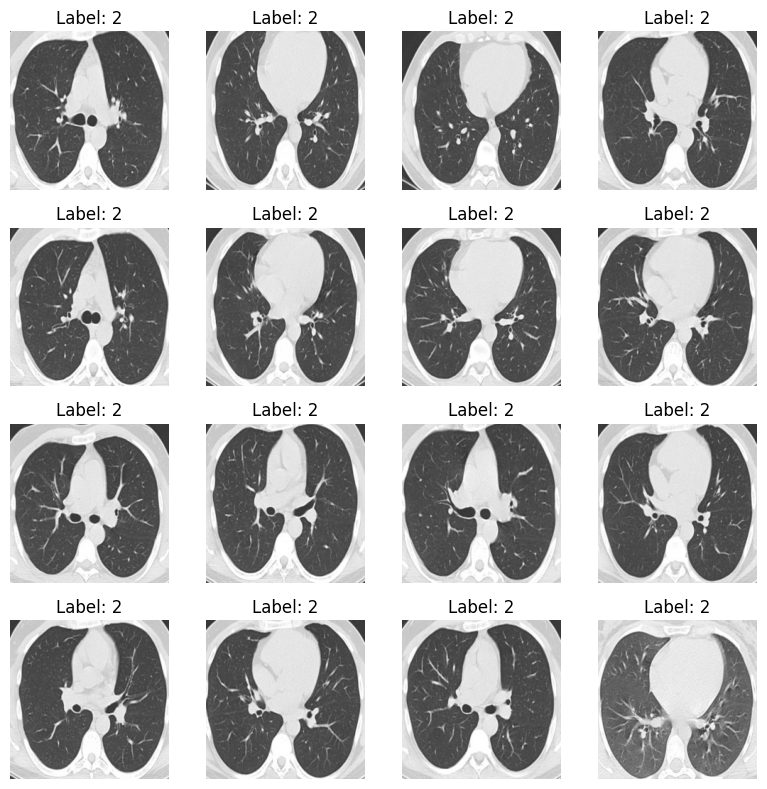

In [ ]:
# show 16 image from train_dataset using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = train_data.__getitem__(i)
    axes[row, col].imshow(im.transpose(1, 2, 0))  # Use transpose for NumPy arrays
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Trainning

In [ ]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_classes = 3  # Get the number of classes from your dataset
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features, num_classes)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = vgg16
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weight=None
    for ep in range(epochs):
        print(f"Epoch {ep+1}\n-------------------------------")
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        val_loss = test_loss(val_loader, model, loss_fn)
        print(f"Epoch {ep+1} Train loss: {train_loss:>7f}  Val loss: {val_loss:>7f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_weight=model.state_dict().copy()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    print("Done!")
    model.load_state_dict(best_weight)
    return model

def test_loss(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= batch
    return train_loss

In [ ]:
learning_rate = 1e-3
batch_size = 32
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=epochs)

Epoch 1
-------------------------------
Epoch 1 Train loss: 1.064067  Val loss: 1.059608
Epoch 2
-------------------------------
Epoch 2 Train loss: 0.876166  Val loss: 1.062092
Epoch 3
-------------------------------
Epoch 3 Train loss: 0.692468  Val loss: 1.077444
Epoch 4
-------------------------------
Epoch 4 Train loss: 0.558296  Val loss: 1.178569
Early stopping!
Done!


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    true_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted_labels, true_labels

In [ ]:
loss_fn = nn.CrossEntropyLoss()

test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 54.2%, Avg loss: 0.960872 



([2,
  2,
  2,
  2,
  2,
  0,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  2,
  0,
  1,
  2,
  2,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  2,
  0,
  2,
  0,
  2,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  2,
  1,
  2,
  0,
  0,
  2,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  0,
  2,
  2,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  0,
  2,
  0,
  2,
  0,
  0,
  0,
  2,
  0,
  2,
  1,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  2,
  1,
  2,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  2,
  2,
  0,
  0,
  1,
  2,
  0,
  2,
  1,
  2,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  2,
  0,
  1,
  0,


# Result

Using : T4, Model : VGG16 (pre-trained)



```
Rounds 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1 Train loss: 1.058820  Val loss: 1.074311
Epoch 2
-------------------------------
Epoch 2 Train loss: 0.901308  Val loss: 1.034416
Epoch 3
-------------------------------
Epoch 3 Train loss: 0.717105  Val loss: 1.029933
Epoch 4
-------------------------------
Epoch 4 Train loss: 0.607693  Val loss: 1.063521
Epoch 5
-------------------------------
Epoch 5 Train loss: 0.503523  Val loss: 1.126739
Epoch 6
-------------------------------
Epoch 6 Train loss: 0.425742  Val loss: 1.249330
Early stopping!
Done!
```





```
Rounds 2
-------------------------------
Epoch 1
-------------------------------
Epoch 1 Train loss: 1.064067  Val loss: 1.059608
Epoch 2
-------------------------------
Epoch 2 Train loss: 0.876166  Val loss: 1.062092
Epoch 3
-------------------------------
Epoch 3 Train loss: 0.692468  Val loss: 1.077444
Epoch 4
-------------------------------
Epoch 4 Train loss: 0.558296  Val loss: 1.178569
Early stopping!
Done!
```





```
Test Error:
 Accuracy: 55.3%, Avg loss: 0.912262
```



Test Error: 
 Accuracy: 54.2%, Avg loss: 0.960872 

              precision    recall  f1-score   support

           0       0.67      0.49      0.57       114
           1       0.53      0.69      0.60        67
           2       0.45      0.50      0.47        94

    accuracy                           0.54       275
   macro avg       0.55      0.56      0.55       275
weighted avg       0.56      0.54      0.54       275



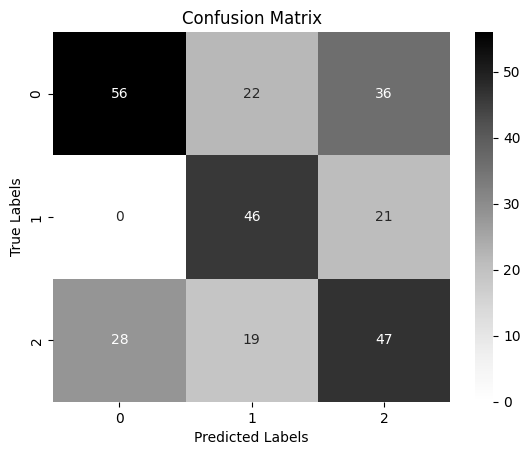

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predicted, true = test_loop(test_loader, model, loss_fn)

cm = confusion_matrix(true, predicted)

print(classification_report(true, predicted))


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Grays')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()